In [1]:
# Sample to be processed
study = 'scmznos_valtor_combined'


In [2]:
# Input/output/resource directories
place = 'nemo'
scratchdir = f"/plus/scratch/users/scott/projects/scmznos_valtor"
rawdir = f'{scratchdir}/raw_data'
outdir = f'{scratchdir}/project_results'
datadir = f'{scratchdir}/resources'
commonsdir = '/plus/data/@data_scott/common_resources'
syncdir = '/home/scott/Sync/scmznos_sync'


In [3]:
# Load libraries
import os
import sklearn
import pickle
import pandas as pd
import numpy as np
import scipy
from scipy.sparse import csr_matrix
from scipy import io

import scanpy as sc
import anndata as ad
import pybiomart as pbm
import leidenalg as la
import scrublet as scr

import graphtools as gt
from pygsp import graphs, filters
import phate
import magic
import scprep
import sklearn
import meld

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import time
import natsort

# Package settings
sc.settings.autosave = False
sc.settings.figdir = f'{syncdir}/'
np.random.seed(42)
font = {'size'   : 14}
mpl.rc('font', **font)
mpl.rcParams['animation.embed_limit'] = 1000
mpl.rcParams['pdf.fonttype'] = 42


In [4]:
# Show loaded libraries
import session_info
session_info.show()

In [5]:
# Import sequence analysis tools
import pyranges as pr
import pybedtools
import Bio
import pysam


In [6]:
# Homemade utility functions
import pyFunctions
from pyFunctions.annotation import *


### Load temporal HVG modules

In [7]:
# Load preprocessed data
sdata = sc.read_h5ad(f'{scratchdir}/published_data/Anndata_scmznps_cells_preprocessed_annotated.h5ad')
sdata

AnnData object with n_obs × n_vars = 10551 × 19782
    obs: 'Sample', 'predicted_doublets', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'Raw_GFPCAAX', 'Raw_DSRED38WT', 'Raw_HCD4ENRICHED', 'Expression_GFPCAAX', 'Expression_DSRED38WT', 'Expression_HCD4ENRICHED', 'Condition', 'KO_clusters', 'Tissue_prediction', 'Tissue_prediction_probability', 'Tissue_KO_clusters'
    var: 'gene_ids', 'gene_symbol', 'EnsemblID', 'Description', 'Biotype', 'EntrezGeneID', 'ZFIN_ID', 'ZFIN_symbol', 'MouseEnsemblID', 'MouseGeneSymbol', 'HumanEnsemblID', 'HumanGeneSymbol', 'Chromosome', 'Start', 'End', 'Strand', 'AnySpecies_TFs', 'highly_variable', 'n_cells_by_counts', 'pct_cells_detected', 'mean_counts', 'total_counts', 'Max_detection', 'Max_KO_cluster_detection', 'Clusters_fine', 'Clusters_fine_reIDs', 'localization_score', 'kTotal', 'kWithin', 'kOut', 'kDiff', 'Importance_rank', 'mir430_seed', 'maternal', 'first_wave_MZT', 'second_wave_MZT', 'DEG_nps_strongly_down', 'NPS_open_5kb', 'Zygo

In [8]:
# Load GSPA gene module annotation
cluster_annotation = pd.read_csv(f'{outdir}/scMZnps_HVG_cluster_annotation.csv', index_col=0)
cluster_annotation['Cluster'][cluster_annotation['Cluster'].isna()] = 'Silent'
cluster_annotation['Cluster'] = cluster_annotation['Cluster'].str.removeprefix('#')
with open(f'{outdir}/HVG_cluster_order.pkl', 'rb') as f:
    cluster_order = pickle.load(f)
cluster_order = [i.removeprefix('#') for i in cluster_order] + ['Silent']

cluster_annotation['Cluster'] = cluster_annotation['Cluster'].astype('category')
cluster_annotation['Cluster'] = cluster_annotation['Cluster'].cat.reorder_categories(cluster_order)
cluster_annotation


/tmp/ipykernel_520888/3701530852.py:2: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  cluster_annotation = pd.read_csv(f'{outdir}/scMZnps_HVG_cluster_annotation.csv', index_col=0)
/tmp/ipykernel_520888/3701530852.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.or

,gene_ids,gene_symbol,EnsemblID,Description,Biotype,EntrezGeneID,ZFIN_ID,ZFIN_symbol,MouseEnsemblID,MouseGeneSymbol,...,MZnps_2.5hpf,MZnps_3hpf,MZnps_3.5hpf,MZnps_4hpf,MZnps_4.5hpf,MZnps_5hpf,MZnps_5.5hpf,MZnps_6hpf,Cluster,Cluster_rho
crebl2,ENSDARG00000104049,crebl2,ENSDARG00000104049,cAMP responsive element binding protein-like 2...,protein_coding,436975.0,ZDB-GENE-040718-456,crebl2,ENSMUSG00000032652,Crebl2,...,-1.327899,-1.577992,-1.156429,-0.831662,0.047754,1.006599,2.131740,2.701926,5e4fa2,0.882353
msgn1,ENSDARG00000070546,msgn1,ENSDARG00000070546,mesogenin 1 [Source:ZFIN;Acc:ZDB-GENE-030722-1],protein_coding,360135.0,ZDB-GENE-030722-1,msgn1,ENSMUSG00000047002,Msgn1,...,-0.430963,-0.470814,-0.482001,-0.381351,-0.226508,0.014042,0.217073,0.119757,ffffbe,0.500000
si:ch211-51e12.7,ENSDARG00000045914,si:ch211-51e12.7,ENSDARG00000045914,si:ch211-51e12.7 [Source:ZFIN;Acc:ZDB-GENE-030...,protein_coding,336335.0,ZDB-GENE-030131-8279,si:ch211-51e12.7,NaN,NaN,...,-0.688686,-0.741290,-0.757083,-0.618424,-0.123607,0.138116,0.790652,0.938153,3d95b8,0.917647
mrps10,ENSDARG00000045913,mrps10,ENSDARG00000045913,mitochondrial ribosomal protein S10 [Source:ZF...,protein_coding,565937.0,ZDB-GENE-040914-39,mrps10,ENSMUSG00000034729,Mrps10,...,-2.225115,-1.920836,-1.326585,-1.204190,-0.917511,-0.645735,-0.486574,-0.474256,ffffbe,0.920588
tulp4a,ENSDARG00000045911,tulp4a,ENSDARG00000045911,TUB like protein 4a [Source:ZFIN;Acc:ZDB-GENE-...,protein_coding,557730.0,ZDB-GENE-060503-215,tulp4a,ENSMUSG00000034377,Tulp4,...,-1.500882,-1.341888,-1.420992,-1.032009,-1.246192,-0.419469,0.322850,0.745297,86cfa5,0.614706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CABZ01113599.1,ENSDARG00000108136,CABZ01113599.1,ENSDARG00000108136,NaN,protein_coding,NaN,NaN,NaN,ENSMUSG00000040325,Dcaf1,...,0.043212,0.475337,0.638223,0.606983,1.113439,0.492812,0.365627,-0.788417,dd4a4c,0.255882
exosc3-1,ENSDARG00000104246,exosc3-1,ENSDARG00000104246,wu:fc33b09 [Source:NCBI gene (formerly Entrezg...,protein_coding,324574.0,NaN,NaN,ENSMUSG00000028322,Exosc3,...,-1.991651,-1.449962,-0.629835,0.245112,0.770853,0.648165,1.039378,1.144869,5e4fa2,0.938235
CABZ01048453.1,ENSDARG00000104434,CABZ01048453.1,ENSDARG00000104434,NaN,protein_coding,NaN,NaN,NaN,ENSMUSG00000029250,Polr2b,...,-0.625981,-0.851610,-0.598030,-0.352210,-0.567214,-0.146626,0.166376,0.209551,3d95b8,0.929412
CABZ01048392.1,ENSDARG00000111876,CABZ01048392.1,ENSDARG00000111876,NaN,protein_coding,110438503.0,NaN,NaN,ENSMUSG00000025898,Cwf19l2,...,-0.685503,-0.612394,-0.446635,-0.505557,-0.615825,-0.889753,-1.367593,-1.536927,f98e52,0.950000


In [9]:
# Create color matrix
with open(f'{outdir}/HVG_cluster_order.pkl', 'rb') as f:
    cols_hex = pickle.load(f)

cols_hex = cols_hex + ['grey']

colours = pd.DataFrame({'Cluster': cols_hex})
colours.index = cluster_order
colours

,Cluster
fed481,#fed481
9e0142,#9e0142
dd4a4c,#dd4a4c
f98e52,#f98e52
86cfa5,#86cfa5
ffffbe,#ffffbe
3d95b8,#3d95b8
5e4fa2,#5e4fa2
d6ee9b,#d6ee9b
Silent,grey


### Output a bedfile of ranges for visualising accessibility around promoters with deeptools

In [10]:
# Use Liyuns canonical start sit|es (TSS)
atac_genes = pd.read_csv(f'{datadir}/20240312_Liyun_ATAC_genes.csv')
atac_genes

,chr,CTSS_coord,gene,gene_name,WT_4h_CiT_exon,MZ_NOS_4h_CiT_exon,gene_biotype,category,intron_length,WT_4h_CiT_intron,MZ_NOS_4h_CiT_intron,enhancer,seq
0,4,42645880,ENSDARG00000117206,RF00003,255.054273,383.950513,snRNA,Unaffected,0,0.000000,0.000000,NaN,GGGTTGCTGGCCCATTCCCCATGCTCGGTGGCTGGGCATCACCGCC...
1,22,1586059,ENSDARG00000117185,si:ch211-255f4.11,1668.407743,837.989763,protein_coding,Unaffected,251,407.739532,0.000000,NaN,CTTTAATAGCATATTGTGTCACCTACAGGATATAACACATGATGTT...
2,4,41343089,ENSDARG00000117166,RF00003,619.797631,372.395597,snRNA,Unaffected,0,0.000000,0.000000,NaN,GGGGAATTCGCAGGGGTCAGCGTGGCCGGAGTGCAATGGCCAAGCC...
3,4,44672985,ENSDARG00000117156,si:dkey-7j22.4,343.330059,504.335526,protein_coding,Unaffected,5249,376.302651,194.700373,NaN,CAGCAGGTACATAATTTAGCACTGAATAAAAAAACTAACTTTAATC...
4,4,50463607,ENSDARG00000117132,BX663613.1,299.299432,176.105898,protein_coding,Unaffected,14483,89.743237,34.616432,NaN,TTTTGCGCTCCACACTTCTATCCAGTAGGTGGCGGGAATGCACCAT...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31356,14,14992908,ENSDARG00000117200,BX119314.1,26.317189,27.094604,protein_coding,NaN,1993,0.000000,0.000000,NaN,CGTAAGTTATTTAGTGTGTTTTTAACAATTTTCATAAGAAATAACA...
31357,10,34107919,ENSDARG00000117202,pimr144,3.902234,4.329016,protein_coding,NaN,16187,3.793512,5.956225,NaN,GCCATTGTATCACTGTACTGTTGAATCGCAGAAAGTACTGAACTAC...
31358,19,17373631,ENSDARG00000117203,RF00424,0.000000,0.000000,scaRNA,NaN,0,0.000000,0.000000,NaN,ACTTCAAGCTAATCAGGACTTGTTAGTTGGTCATGTGCTGATGCTC...
31359,12,47774807,ENSDARG00000117204,LO017725.1,0.000000,0.000000,protein_coding,NaN,342,0.000000,0.000000,peak_24198/peak_24199,GGTAACCTCTCCTCCACGCCTGCAGCAGGTTCTTCCAGACCCCGAA...


### Create a peak list per module

In [11]:
# # Import enhancer list from deep tools
# enhancer_info = pd.read_csv(f'{syncdir}/scMZnps_HVG_cluster_Enhancers.csv', index_col=0)

In [12]:
# Create bed files of enhancers (note using summit only to define region)
import itertools

atac_peaks = pd.read_csv(f'{datadir}/20240312_Liyun_ATAC_peaks.csv')

enhancer_info_dfs = []

for clust in colours.index.to_list():
    
    # Get active enhancers associated with module genes
    mod_genes = cluster_annotation[cluster_annotation['Cluster'] == clust].EnsemblID.to_list()
    print(f'Number of genes in module {clust}:{len(mod_genes)}')
    enhancer_genes = atac_genes[~atac_genes.enhancer.isna()]
    enhancer_genes = enhancer_genes[enhancer_genes.gene.isin(mod_genes)]
    print(f'Number of genes with enhancers in module and ATAC peak {clust}:{enhancer_genes.shape[0]}')

    
    # List enhancers
    enhancers = enhancer_genes.enhancer.to_list()
    enhancers = [i.split('/') for i in enhancers]
    enhancers = list(itertools.chain.from_iterable(enhancers))
    print(f'Number enhancers in module {clust}:{len(enhancers)}')
    
    # Create bed file of enhancers
    enhancer_peaks = atac_peaks[atac_peaks.peak.isin(enhancers)]
    enhancer_info = enhancer_peaks[['chr', 'summit', 'summit', 'peak', 'MZnps_3_rep_avg']]
    enhancer_info['strand'] = '.'
    enhancer_info.columns = ['Chromosome', 'Start', 'End', 'Name', 'Score', 'Strand']
    enhancer_info['End'] = enhancer_info['End'].astype(int) + 1
    enhancer_info.index = enhancer_info.Name
    enhancer_info['Module'] = clust
    enhancer_info_dfs.append(enhancer_info)

atac_peaks.index = atac_peaks.peak
enhancer_info = pd.concat(enhancer_info_dfs, axis=0)
enhancer_info = enhancer_info.merge(atac_peaks, how='left', left_index=True, right_index=True)
enhancer_info


Number of genes in module fed481:625
Number of genes with enhancers in module and ATAC peak fed481:201
Number enhancers in module fed481:269
Number of genes in module 9e0142:1661
Number of genes with enhancers in module and ATAC peak 9e0142:495
Number enhancers in module 9e0142:654
Number of genes in module dd4a4c:796
Number of genes with enhancers in module and ATAC peak dd4a4c:238
Number enhancers in module dd4a4c:317
Number of genes in module f98e52:498
Number of genes with enhancers in module and ATAC peak f98e52:145
Number enhancers in module f98e52:196
Number of genes in module 86cfa5:637
Number of genes with enhancers in module and ATAC peak 86cfa5:240
Number enhancers in module 86cfa5:379
Number of genes in module ffffbe:831
Number of genes with enhancers in module and ATAC peak ffffbe:360
Number enhancers in module ffffbe:557
Number of genes in module 3d95b8:802
Number of genes with enhancers in module and ATAC peak 3d95b8:343
Number enhancers in module 3d95b8:502
Number of ge

/tmp/ipykernel_520888/2478257375.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  enhancer_info['strand'] = '.'
/tmp/ipykernel_520888/2478257375.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  enhancer_info['End'] = enhancer_info['End'].astype(int) + 1
/tmp/ipykernel_520888/2478257375.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

,Chromosome,Start,End,Name,Score,Strand,Module,peak,chr,start,...,WT_sdt_mut,N-/P-/S-,N+/P-/S-,N-/P+/S-,N+/P+/S-,N-/P+/S+_ATAC,N+/P+/S+,Category,Location,seq
Name,,,,,,,,,,,,,,,,,,,,,
peak_2006,1,16459518,16459519,peak_2006,2.768110,.,fed481,peak_2006,1,16459417,...,2.347750,3.069398,4.204009,4.031712,3.088788,3.313761,2.995159,Other,Other region,GTTTTACGACCCCAAGTACACCAGTCTGCAGCCGAGGAGGGGTAGA...
peak_2240a,1,18859357,18859358,peak_2240a,5.797076,.,fed481,peak_2240a,1,18859259,...,4.719109,6.229202,6.269211,7.533243,6.543267,5.163335,6.004831,Other,Active enhancer,ATTAGTGAGGAAACGTACGCCATGCCCCCCCTTCGCCATCTCACCC...
peak_2242,1,18860775,18860776,peak_2242,1.909407,.,fed481,peak_2242,1,18860712,...,1.501275,2.205602,2.241698,2.891102,2.241284,2.054750,1.936856,Other,Active enhancer,ATCTAACATTTGTAAATTATTCACGCGTTTCCCCTTCAGCGGCGCA...
peak_3670,1,31531401,31531402,peak_3670,0.717563,.,fed481,peak_3670,1,31531348,...,0.873430,0.747832,1.401086,0.847087,1.246823,0.489744,1.590304,Other,Active enhancer,AAACCATATGGCCTCCAAACGTTTGCGTCTTTTTTATGTGGCTGGA...
peak_3671,1,31532719,31532720,peak_3671,1.741476,.,fed481,peak_3671,1,31532620,...,1.230106,1.799862,2.375021,2.176466,2.012973,2.277101,1.640257,Other,Other region,TGAGAGAGACGACATGGGGGACAGACATAATTTGTGCACAGTCTTG...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
peak_162047,9,23355623,23355624,peak_162047,0.412349,.,Silent,peak_162047,9,23355550,...,1.413369,0.318471,1.283437,0.652701,1.186729,0.535582,1.166001,Group 2,Active enhancer,AAAGTGGAGATTGCCTTCATGATCTCATTATGGCATCATCTTCTAC...
peak_162122,9,24033418,24033419,peak_162122,1.214205,.,Silent,peak_162122,9,24033358,...,1.126715,1.874589,2.160571,1.508445,1.939602,1.484009,1.337848,Other,Other region,TCGGTTTAACATCTCATCTGAAAAACGGTGCACACTGAGCAGTATA...
peak_162123,9,24034963,24034964,peak_162123,0.025850,.,Silent,peak_162123,9,24034905,...,0.842423,0.081435,0.109852,0.034145,0.056635,0.037044,0.326201,Group 1,Other region,ACTTTCTGTTTGCTTAGTACTGTGGTTTGGATCATGTTGCTCATGG...


In [13]:
# Get total enhancer genes
atac_peaks = pd.read_csv(f'{datadir}/20240312_Liyun_ATAC_peaks.csv')

enhancer_genes = atac_genes[~atac_genes.enhancer.isna()]
# enhancer_genes = enhancer_genes[enhancer_genes.gene.isin(cluster_annotation.EnsemblID.to_list())]

# List enhancers
enhancers = enhancer_genes.enhancer.to_list()
enhancers = [i.split('/') for i in enhancers]
enhancers = list(itertools.chain.from_iterable(enhancers))
len(enhancers)

11030

In [14]:
# Load data from Liyins paper
atac_peaks = pd.read_csv(f'{datadir}/20240312_Liyun_ATAC_peaks.csv')
atac_peaks = atac_peaks.rename(columns={"peak": "Name", "chr": "Chromosome", 'start': 'Start', 'end': 'End'})
atac_peaks['Strand'] = '.'
atac_peaks = atac_peaks[atac_peaks.Location != 'Promoter'].reset_index(drop=True)
atac_peaks_pr = pr.PyRanges(atac_peaks)
atac_peaks

/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}


,Name,Chromosome,Start,End,summit,WT_3_rep_avg,MZnps_3_rep_avg,WT_rescue,MZnps_rescue,Nanog_rescue,...,N-/P-/S-,N+/P-/S-,N-/P+/S-,N+/P+/S-,N-/P+/S+_ATAC,N+/P+/S+,Category,Location,seq,Strand
0,peak_8,1,17868,17966,17920,1.502159,0.598221,1.991756,0.734989,0.367415,...,0.825037,0.751096,0.851316,1.366838,0.995494,0.774732,Group 2,Other region,ACAGTAAAGCAGAATTTACTAGAAGCTGCGGCAGCCTCAATCTTAC...,.
1,peak_43a,1,102486,102764,102564,0.564367,0.575508,1.023220,0.567902,0.509804,...,0.697015,1.109165,0.797563,1.249014,1.192366,0.826049,Other,Other region,TGTGTGTGTGTGCATGTGTGTGTGTGTAGGACCAGTTTAACACACA...,.
2,peak_50,1,145307,145451,145405,0.851550,0.815559,1.097178,0.769834,0.632608,...,1.000989,0.934299,1.077092,0.750861,0.237536,1.743570,Other,Other region,TGGGAACTGATTGGATTGTTGAAAGATAGGCGATGCTGACAAAATG...,.
3,peak_62,1,172222,172316,172278,0.774569,0.663663,1.115558,0.576975,0.579420,...,1.098019,0.917129,1.021879,0.825517,1.064265,1.113142,Other,Active enhancer,TCATCATCTCTCTCGTCCTGAATTTCCTCTCATTTCTTCTGTTCTG...,.
4,peak_63,1,174792,175008,174857,1.334169,0.535607,1.948378,0.516336,0.626170,...,0.646932,1.068157,0.719271,1.393686,0.638537,1.048880,Group 2,Other region,ACAGCCTGAAACACACACACACACACACACACACAATGATCAGTGT...,.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37972,peak_166402,9,56421284,56421433,56421379,1.867618,1.973649,2.596763,2.216817,1.718619,...,2.065408,1.757597,2.400141,1.454834,1.468106,2.204794,Other,Other region,AGAGAAGCTGGAGCTGAATGCTGGAATATCTCTGGTCTGCACAGAG...,.
37973,peak_166403b,9,56425966,56426110,56426071,1.176245,0.589178,1.353649,0.640750,0.415190,...,0.777171,1.067987,0.994542,0.398302,0.344810,1.573671,Other,Other region,GCTGCTGGCCAGCTAAACCAATCAAACACCCCAGAATGAGCAAATG...,.
37974,peak_166404,9,56427939,56428127,56428018,2.596806,3.937465,3.421492,4.153963,2.834622,...,4.599406,2.763245,4.610956,2.858762,3.355177,3.891692,Other,Other region,CACTCACACAAACACACACACACACCTGCACTGCTGCTGAAGGTGA...,.
37975,peak_166408,9,56437704,56437837,56437800,0.846545,0.759659,0.948833,0.920855,0.655369,...,0.682550,0.761082,0.752349,0.585261,0.306268,0.810297,Other,Other region,AGAACCACCACACACTGCTGGGAGCCGCTGGATGAGGGCCGGGTCG...,.


### Annotate Liyun Peaks with intersect with NPS peaks

In [15]:
# Load NPS peak files
nanog = pr.read_bed(f'{datadir}/Nanog_3.5h_uniq_q_0.05_peaks_highest_rm_MT_K.narrowPeak')
pou5f3 = pr.read_bed(f'{datadir}/Pou5f3_4_hpf_uniq_q_0.05_peaks_highest_rm_MT_K.narrowPeak')
sox19b = pr.read_bed(f'{datadir}/Sox19b_3.7hpf_uniq_q_0.05_peaks_highest_rm_MT_K.narrowPeak')

/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}
/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}
/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in

In [16]:
# Annotate those bound by NPS
for mark, NP in zip(['N', 'P', 'S'], [nanog, pou5f3, sox19b]):
    tmp2_peaks = isOverlap(atac_peaks_pr, NP, feature_type = None, name = mark)
    tmp2_peaks = tmp2_peaks.as_df()
    tmp2_peaks = tmp2_peaks[tmp2_peaks[f'{mark}_overlap']]
    atac_peaks[mark] = atac_peaks_pr.Name.isin(tmp2_peaks.Name)

atac_peaks['N/P/S'] = atac_peaks[['N', 'P', 'S']].sum(axis=1) > 0
atac_peaks['NPS'] = atac_peaks[['N', 'P', 'S']].sum(axis=1) == 3

atac_peaks['NP'] = (atac_peaks[['N', 'P']].sum(axis=1) == 2) & (atac_peaks[['S']].sum(axis=1) == 0)
atac_peaks['NS'] = (atac_peaks[['N', 'S']].sum(axis=1) == 2) & (atac_peaks[['P']].sum(axis=1) == 0)
atac_peaks['PS'] = (atac_peaks[['P', 'S']].sum(axis=1) == 2) & (atac_peaks[['N']].sum(axis=1) == 0)

atac_peaks['N'] = (atac_peaks[['N']].sum(axis=1) == 1) & (atac_peaks[['P', 'S']].sum(axis=1) == 0)
atac_peaks['P'] = (atac_peaks[['P']].sum(axis=1) == 1) & (atac_peaks[['N', 'S']].sum(axis=1) == 0)
atac_peaks['S'] = (atac_peaks[['S']].sum(axis=1) == 1) & (atac_peaks[['P', 'N']].sum(axis=1) == 0)


/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/pyranges/methods/init.py:162: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  empty_removed = df.groupby("Chromosome")
/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}
/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/pyranges/methods/init.py:162: FutureWarning: The default of observed=False is deprecated and will be changed to True in a fu

### Look at enrichment for N, P, S, N/P/S or NPS enrichment per module

In [17]:
# Create a dictionary of genes of interest with respect to MZT for enrichment testing
NPS_dict = {}
NPS_dict['N'] = atac_peaks[atac_peaks['N']]['Name'].to_list()
NPS_dict['P'] = atac_peaks[atac_peaks['P']]['Name'].to_list()
NPS_dict['S'] = atac_peaks[atac_peaks['S']]['Name'].to_list()
NPS_dict['NP'] = atac_peaks[atac_peaks['NP']]['Name'].to_list()
NPS_dict['NS'] = atac_peaks[atac_peaks['NS']]['Name'].to_list()
NPS_dict['PS'] = atac_peaks[atac_peaks['PS']]['Name'].to_list()
NPS_dict['N/P/S'] = atac_peaks[atac_peaks['N/P/S']]['Name'].to_list()
NPS_dict['NPS'] = atac_peaks[atac_peaks['NPS']]['Name'].to_list()

NPS_dict

{'N': ['peak_168b',
  'peak_211',
  'peak_242',
  'peak_245',
  'peak_248',
  'peak_254c',
  'peak_279b',
  'peak_288',
  'peak_342a',
  'peak_344b',
  'peak_452',
  'peak_549',
  'peak_618',
  'peak_620',
  'peak_726',
  'peak_744',
  'peak_752a',
  'peak_778',
  'peak_791a',
  'peak_840',
  'peak_857',
  'peak_867',
  'peak_885',
  'peak_888',
  'peak_1006',
  'peak_1070',
  'peak_1080',
  'peak_1112',
  'peak_1177',
  'peak_1179',
  'peak_1191',
  'peak_1280',
  'peak_1455b',
  'peak_1480',
  'peak_1522',
  'peak_1634',
  'peak_1663b',
  'peak_1677',
  'peak_1726',
  'peak_1743',
  'peak_1780',
  'peak_1925',
  'peak_1935',
  'peak_1936',
  'peak_1956',
  'peak_1970',
  'peak_1985',
  'peak_2016',
  'peak_2022',
  'peak_2049',
  'peak_2052',
  'peak_2054',
  'peak_2055',
  'peak_2071b',
  'peak_2103',
  'peak_2174',
  'peak_2207',
  'peak_2238',
  'peak_2278',
  'peak_2340',
  'peak_2410',
  'peak_2442b',
  'peak_2486',
  'peak_2536',
  'peak_2544',
  'peak_2549',
  'peak_2563',
  '

In [18]:
# Get top gene list removing genes that are ubiquitous
import gseapy as gp

res = 'Module'

res_df = []

for clust in colours.index.to_list():
    peak_list = enhancer_info[enhancer_info[res] == clust].peak.to_list()
    print(f'Number of peaks in {clust}: {len(peak_list)}')

    if len(peak_list) <= 2:
        break
    
    # Get significantly enriched terms
    enr2 = gp.enrich(gene_list=peak_list, # or gene_list=glist
                     gene_sets=NPS_dict, # kegg is a dict object
                     # background=atac_peaks.Name.to_list(), # or "hsapiens_gene_ensembl", or int, or text file, or a list of genes
                     background=enhancers, # or "hsapiens_gene_ensembl", or int, or text file, or a list of genes
                     outdir=None,
                     verbose=True,
                     cutoff=1.0)
    
    results = enr2.results
    results = results.sort_values('P-value', ascending=True)
    results['log10_p'] = -np.log10(results['Adjusted P-value'])
    results['logOR'] = np.log2(results['Odds Ratio'])

    results['Module'] = clust
    
    res_df.append(results)
    # results.to_csv(f'{outdir}/clusters/TFBS_DEGs_{res}_cluster_{clust}.csv')
    print(results.head(30))
res_df = pd.concat(res_df, axis=0)

2024-12-11 17:37:00,167 [INFO] Input dict object named with gs_ind_0
2024-12-11 17:37:00,168 [INFO] Run: gs_ind_0 
2024-12-11 17:37:00,174 [INFO] Done.
2024-12-11 17:37:00,180 [INFO] Input dict object named with gs_ind_0
2024-12-11 17:37:00,180 [INFO] Run: gs_ind_0 
2024-12-11 17:37:00,186 [INFO] Done.
2024-12-11 17:37:00,191 [INFO] Input dict object named with gs_ind_0
2024-12-11 17:37:00,191 [INFO] Run: gs_ind_0 
2024-12-11 17:37:00,196 [INFO] Done.
2024-12-11 17:37:00,201 [INFO] Input dict object named with gs_ind_0
2024-12-11 17:37:00,201 [INFO] Run: gs_ind_0 
2024-12-11 17:37:00,206 [INFO] Done.
2024-12-11 17:37:00,211 [INFO] Input dict object named with gs_ind_0
2024-12-11 17:37:00,211 [INFO] Run: gs_ind_0 
2024-12-11 17:37:00,216 [INFO] Done.
2024-12-11 17:37:00,221 [INFO] Input dict object named with gs_ind_0
2024-12-11 17:37:00,221 [INFO] Run: gs_ind_0 
2024-12-11 17:37:00,227 [INFO] Done.
2024-12-11 17:37:00,231 [INFO] Input dict object named with gs_ind_0
2024-12-11 17:37:00

Number of peaks in fed481: 263
   Gene_set   Term   Overlap   P-value  Adjusted P-value  Odds Ratio  \
2  gs_ind_0     NP    20/402  0.010514          0.063511    1.852261   
5  gs_ind_0      P   47/1215  0.015878          0.063511    1.451683   
1  gs_ind_0  N/P/S  141/4512  0.061708          0.164554    1.214745   
6  gs_ind_0     PS    18/449  0.088218          0.176435    1.476701   
4  gs_ind_0     NS    15/473  0.367714          0.588342    1.157184   
7  gs_ind_0      S   71/2490  0.509590          0.601511    1.009292   
0  gs_ind_0      N    23/807  0.526322          0.601511    1.022569   
3  gs_ind_0    NPS   23/1111  0.964118          0.964118    0.716167   

   Combined Score                                              Genes  \
2        8.437125  peak_113733b;peak_114435;peak_81933;peak_13103...   
5        6.014083  peak_28054;peak_148375;peak_24558c;peak_113733...   
1        3.383484  peak_53849;peak_148375;peak_16126;peak_114435;...   
6        3.585352  peak_92122;pe

In [19]:
# Manually set order of modules
res_df['Module'] = res_df['Module'].astype('category')
res_df['Module'] = res_df['Module'].cat.reorder_categories(colours.index.to_list())
res_df = res_df[res_df['Module'] != 'Silent']


In [20]:
logOR_df = res_df.pivot(columns='Module', index='Term', values='logOR').T
pval_df = res_df.pivot(columns='Module', index='Term', values='Adjusted P-value').T


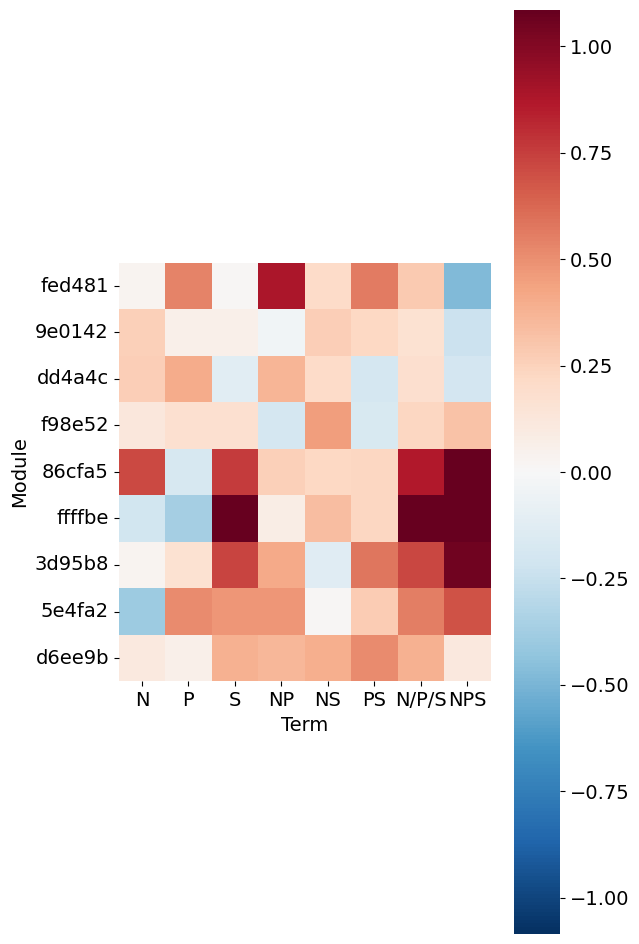

In [21]:
# Make heatmap and clip outlier values
# colour_max = result_promoter.stack().mean() + 2*result_promoter.stack().std()
# colour_min = result_promoter.stack().mean() - 2*result_promoter.stack().std()

# colour_max = logOR_df.stack().quantile(.95)
# colour_min = logOR_df.stack().quantile(.05)

colour_max = max([np.abs(logOR_df.stack().quantile(.95)), np.abs(logOR_df.stack().quantile(.05))])
colour_min = -max([np.abs(logOR_df.stack().quantile(.95)), np.abs(logOR_df.stack().quantile(.05))])


masked = pval_df > 0.05

plt.figure(figsize=(6, 12))
# ax = sns.heatmap(logOR_df[['N', 'P', 'S', 'NP', 'NS', 'PS', 'N/P/S', 'NPS']], annot=False, cmap='RdBu_r', yticklabels=True, square=True, vmin=colour_min, vmax=colour_max, mask=masked[['N', 'P', 'S', 'NP', 'NS', 'PS', 'N/P/S', 'NPS']])
ax = sns.heatmap(logOR_df[['N', 'P', 'S', 'NP', 'NS', 'PS', 'N/P/S', 'NPS']], annot=False, cmap='RdBu_r', yticklabels=True, square=True, vmin=colour_min, vmax=colour_max)
# ax = sns.heatmap(result_promoter, annot=False, cmap='magma', yticklabels=True, square=True)
plt.savefig(f'{syncdir}/Temporal_HVG_NPS_ChIP_binding.pdf')
plt.show()


### Test at enrichment of MZT lists

In [45]:
# Annotate genes with mir430 binding information
GTF = pd.read_csv(f'{datadir}/GRCz11_104_3_prime_UTR.csv')
sdata.var['mir430_seed'] = sdata.var.EnsemblID.isin(GTF[GTF.mir430_motif_seed].gene_id)


/tmp/ipykernel_520888/1650237759.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  GTF = pd.read_csv(f'{datadir}/GRCz11_104_3_prime_UTR.csv')


In [46]:
# Load and annotate Amaral annotations
MZT_Amaral = pd.read_csv(f'{commonsdir}/gene_lists/20240912_MZT_gene_annotation_Amaral_2024.csv', index_col=0)[['mzt_gene_class', 'target']]
sdata.var['strictly_maternal_Amaral'] = sdata.var.gene_ids.isin(MZT_Amaral[MZT_Amaral.mzt_gene_class.isin(['maternal'])].index.to_list())
sdata.var['maternal_zygotic_Amaral'] = sdata.var.gene_ids.isin(MZT_Amaral[MZT_Amaral.mzt_gene_class.isin(['maternal_zygotic'])].index.to_list())
sdata.var['strictly_zygotic_Amaral'] = sdata.var.gene_ids.isin(MZT_Amaral[MZT_Amaral.mzt_gene_class.isin(['zygotic'])].index.to_list())
sdata.var['total_maternal_Amaral'] = sdata.var.gene_ids.isin(MZT_Amaral[MZT_Amaral.mzt_gene_class.isin(['maternal', 'maternal_zygotic'])].index.to_list())
sdata.var['activated_late_Amaral'] = ~(sdata.var['total_maternal_Amaral'] | sdata.var['strictly_zygotic_Amaral'])
sdata.var['mir430_Amaral'] = sdata.var.gene_ids.isin(MZT_Amaral[MZT_Amaral.target.str.contains('target')].index.to_list())
sdata.var['total_mir430_Amaral'] = sdata.var['mir430_Amaral'] | sdata.var['mir430_seed']

MZT_lists = ['NPS_open_5kb',
             'strictly_maternal_Amaral',
             'maternal_zygotic_Amaral',
             'strictly_zygotic_Amaral',
             'total_mir430_Amaral',
            'mir430_Amaral',
            'mir430_seed']

In [47]:
# Create dictionary of enrichment terms
MZT_dict = {}
for i in MZT_lists:
    MZT_dict[i] = sdata.var[sdata.var[i]].index

In [84]:
# Test for specific absence of first or second wave genes
import gseapy as gp

res_dfs = []
for mod in colours.index.to_list():
    enr2 = gp.enrich(gene_list=cluster_annotation[cluster_annotation['Cluster'] == str(mod)].index.to_list(), # or gene_list=glist
                     gene_sets=MZT_dict, # kegg is a dict object
                     background=sdata.var.index.to_list(), # or "hsapiens_gene_ensembl", or int, or text file, or a list of genes
                     outdir=None,
                     verbose=True)
    
    results = enr2.results
    # results = results[results['Adjusted P-value'] < 0.05].sort_values('Adjusted P-value', ascending=True)
    results = results.sort_values('Adjusted P-value', ascending=True)
    results['mir430'] = np.log2(results['Odds Ratio'])
    results['log10_p'] = -np.log10(results['Adjusted P-value'])
    results['sig'] = results['Adjusted P-value'] < 0.05
    results['logOR'] = np.log2(results['Odds Ratio'])
    results['Module'] = mod
    # results.to_csv(f'{syncdir}/MZT_enrichment_stats_KO_only_genes.csv')
    print(f'Module: {mod}')
    print(results[results.Term == 'total_mir430_Amaral'])
    res_dfs.append(results)
res_df = pd.concat(res_dfs, axis=0) 

2024-12-13 00:25:58,856 [INFO] Input dict object named with gs_ind_0
2024-12-13 00:25:58,857 [INFO] Run: gs_ind_0 
2024-12-13 00:25:58,872 [INFO] Done.
2024-12-13 00:25:58,885 [INFO] Input dict object named with gs_ind_0
2024-12-13 00:25:58,886 [INFO] Run: gs_ind_0 
2024-12-13 00:25:58,901 [INFO] Done.
2024-12-13 00:25:58,910 [INFO] Input dict object named with gs_ind_0
2024-12-13 00:25:58,910 [INFO] Run: gs_ind_0 
2024-12-13 00:25:58,921 [INFO] Done.
2024-12-13 00:25:58,929 [INFO] Input dict object named with gs_ind_0
2024-12-13 00:25:58,929 [INFO] Run: gs_ind_0 
2024-12-13 00:25:58,939 [INFO] Done.
2024-12-13 00:25:58,943 [INFO] Input dict object named with gs_ind_0
2024-12-13 00:25:58,944 [INFO] Run: gs_ind_0 
2024-12-13 00:25:58,950 [INFO] Done.
2024-12-13 00:25:58,955 [INFO] Input dict object named with gs_ind_0
2024-12-13 00:25:58,955 [INFO] Run: gs_ind_0 
2024-12-13 00:25:58,961 [INFO] Done.
2024-12-13 00:25:58,966 [INFO] Input dict object named with gs_ind_0
2024-12-13 00:25:58

Module: fed481
   Gene_set                 Term   Overlap       P-value  Adjusted P-value  \
6  gs_ind_0  total_mir430_Amaral  356/5718  5.239741e-50      1.833909e-49   

   Odds Ratio  Combined Score  \
6    3.253441      369.177655   

                                               Genes    mir430    log10_p  \
6  ezrb;gulp1a;si:dkey-256h2.1;fkbp4;ttc27;rras;t...  1.701966  48.736622   

    sig     logOR  Module  
6  True  1.701966  fed481  
Module: 9e0142
   Gene_set                 Term   Overlap       P-value  Adjusted P-value  \
6  gs_ind_0  total_mir430_Amaral  684/5718  3.195081e-29      7.455189e-29   

   Odds Ratio  Combined Score  \
6    1.722261      113.003295   

                                               Genes    mir430    log10_p  \
6  angel2;clic1;dab2;serac1;esamb;h1m;hdhd3;vps8;...  0.784303  28.127541   

    sig     logOR  Module  
6  True  0.784303  9e0142  
Module: dd4a4c
   Gene_set                 Term   Overlap   P-value  Adjusted P-value  \
6  gs_ind_0

In [85]:
# Manually set order of modules
res_df['Module'] = res_df['Module'].astype('category')
res_df['Module'] = res_df['Module'].cat.reorder_categories(colours.index.to_list())
res_df = res_df[res_df['Module'] != 'Silent']
res_df = res_df[res_df['Term'] == 'total_mir430_Amaral']

In [86]:
logOR_df = res_df.pivot(columns='Module', index='Term', values='logOR').T
pval_df = res_df.pivot(columns='Module', index='Term', values='Adjusted P-value').T


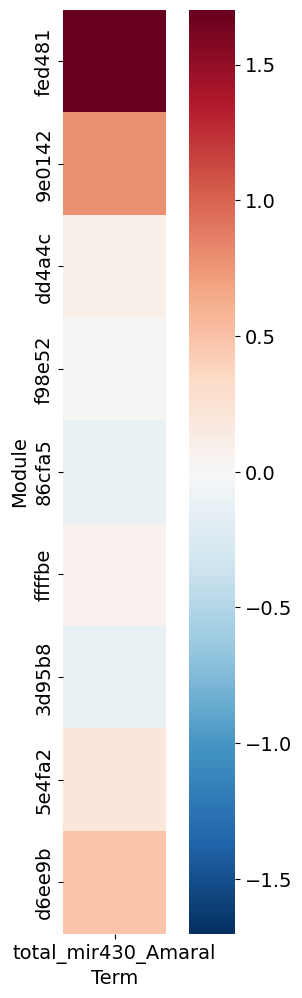

In [87]:
# Make heatmap and clip outlier values
# colour_max = result_promoter.stack().mean() + 2*result_promoter.stack().std()
# colour_min = result_promoter.stack().mean() - 2*result_promoter.stack().std()

# colour_max = logOR_df.stack().quantile(.95)
# colour_min = logOR_df.stack().quantile(.05)

colour_max = max([np.abs(logOR_df.stack().max()), np.abs(logOR_df.stack().min())])
colour_min = -max([np.abs(logOR_df.stack().max()), np.abs(logOR_df.stack().min())])

masked = pval_df > 0.05

plt.figure(figsize=(6, 12))
# ax = sns.heatmap(logOR_df[['total_mir430_Amaral']], annot=False, cmap='RdBu_r', yticklabels=True, square=True, vmin=colour_min, vmax=colour_max, mask=masked[['total_mir430_Amaral']])
ax = sns.heatmap(logOR_df, annot=False, cmap='RdBu_r', yticklabels=True, square=True, vmin=colour_min, vmax=colour_max)
# ax = sns.heatmap(result_promoter, annot=False, cmap='magma', yticklabels=True, square=True)
plt.savefig(f'{syncdir}/Temporal_HVG_mir430_seed.pdf')
plt.show()


In [88]:
res_df = pd.concat(res_dfs, axis=0) 
res_df

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Combined Score,Genes,mir430,log10_p,sig,logOR,Module
2,gs_ind_0,mir430_Amaral,306/3469,3.686277e-75,2.580394e-74,4.510658,773.078309,phlpp1;kdm5c;casp2;per3;fam210aa;acbd5a;pdcd6i...,2.173338,73.588314,True,2.173338,fed481
6,gs_ind_0,total_mir430_Amaral,356/5718,5.239741e-50,1.833909e-49,3.253441,369.177655,ezrb;gulp1a;si:dkey-256h2.1;fkbp4;ttc27;rras;t...,1.701966,48.736622,True,1.701966,fed481
3,gs_ind_0,mir430_seed,235/4145,2.506567e-22,5.848657e-22,2.274889,113.148350,phlpp1;si:ch211-136m16.8;per3;ric8b;acbd5a;pdc...,1.185796,21.232944,True,1.185796,fed481
4,gs_ind_0,strictly_maternal_Amaral,202/3376,2.281454e-21,3.992544e-21,2.323383,110.429171,fam49ba;itgb6;casp2;fam210aa;acbd5a;ezrb;gulp1...,1.216227,20.398750,True,1.216227,fed481
1,gs_ind_0,maternal_zygotic_Amaral,208/4767,8.661326e-08,1.212586e-07,1.572891,25.578062,phlpp1;hnrnpdl;per3;pdcd6ip;ntmt1;ankrd12;sap1...,0.653419,6.916288,True,0.653419,fed481
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,gs_ind_0,strictly_zygotic_Amaral,49/811,2.697285e-02,5.331969e-02,1.357450,4.904366,mespaa;hnf4a;onecut1;slc43a2b;h1f0;plekhg4;tme...,0.440899,1.273112,False,0.440899,Silent
6,gs_ind_0,total_mir430_Amaral,286/5718,3.046840e-02,5.331969e-02,1.144824,3.996656,coq8a;ptpa;zgc:109889;ankfy1;tcf7l1b;slc43a2b;...,0.195126,1.273112,False,0.195126,Silent
3,gs_ind_0,mir430_seed,201/4145,1.631676e-01,2.284347e-01,1.085069,1.967205,coq8a;ptpa;zgc:109889;ankfy1;slc43a2b;CCDC69;s...,0.117787,0.641238,False,0.117787,Silent
1,gs_ind_0,maternal_zygotic_Amaral,225/4767,2.767580e-01,3.228844e-01,1.049851,1.348651,coq8a;dhrs13b;zgc:109889;ankfy1;stom;tcf7l1b;f...,0.070185,0.490953,False,0.070185,Silent


In [89]:
res_df = pd.concat(res_dfs, axis=0) 
res_df['Module'] = res_df['Module'].astype('category')
res_df['Module'] = res_df['Module'].cat.reorder_categories(colours.index.to_list())
res_df = res_df[res_df['Module'] != 'Silent']
res_df['Term'] = res_df['Term'].astype('category')
res_df['Term'] = res_df['Term'].cat.reorder_categories(MZT_lists)

res_df = res_df[~res_df['Term'].isin(['NPS_open_5kb', 'total_mir430_Amaral', 'mir430_Amaral', 'mir430_seed'])]


In [90]:
logOR_df = res_df.pivot(columns='Module', index='Term', values='logOR').T
pval_df = res_df.pivot(columns='Module', index='Term', values='Adjusted P-value').T


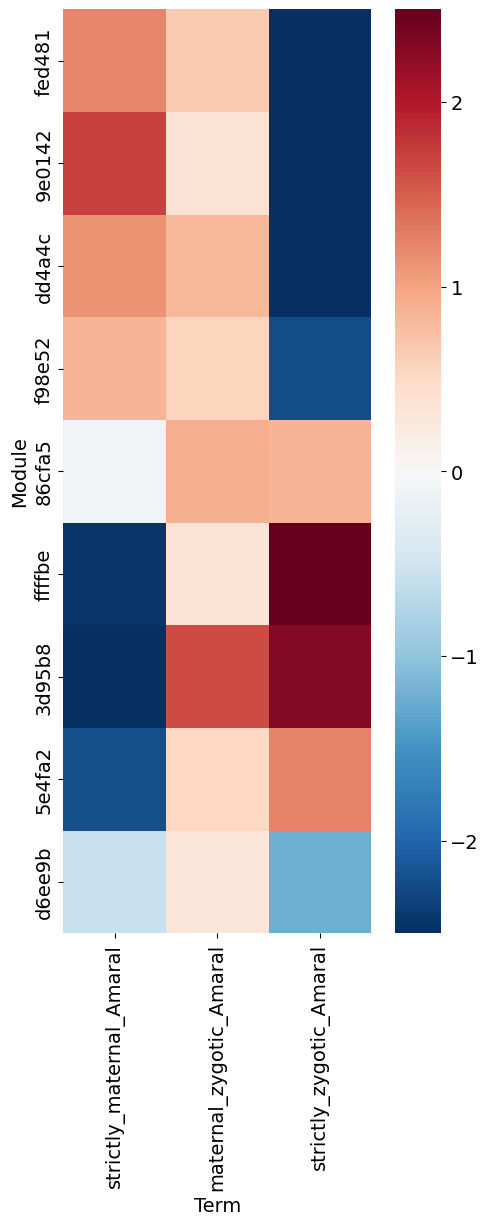

In [97]:
# Make heatmap and clip outlier values
colour_max = max([np.abs(logOR_df.stack().max()), np.abs(logOR_df.stack().min())])
colour_min = -max([np.abs(logOR_df.stack().max()), np.abs(logOR_df.stack().min())])

masked = pval_df > 0.05

plt.figure(figsize=(6, 12))
# ax = sns.heatmap(logOR_df, annot=False, cmap='RdBu_r', yticklabels=True, square=True, vmin=-2.5, vmax=2.5, mask=masked)
ax = sns.heatmap(logOR_df, annot=False, cmap='RdBu_r', yticklabels=True, square=True, vmin=-2.5, vmax=2.5)
# ax = sns.heatmap(result_promoter, annot=False, cmap='magma', yticklabels=True, square=True)
plt.savefig(f'{syncdir}/Temporal_HVG_maternal_zygotic.pdf')
plt.show()


/tmp/ipykernel_520888/2893545721.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  res_df['log10_p'][~res_df['sig']] = 0
/tmp/ipykernel_520888/2893545721.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

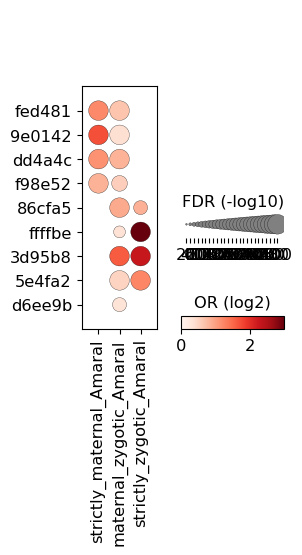

In [95]:
# Create dotplot of enrichment results
# Create bubble plot of enrihcment results
# res_df = res_df[res_df['sig']]
res_df['log10_p'][~res_df['sig']] = 0
res_df['Term'] = res_df['Term'].astype('category')

marker = res_df.pivot_table(values='logOR', columns='Term', index='Module').fillna(0)
pval = res_df.pivot_table(values='log10_p', columns='Term', index='Module').fillna(0)
pval[pval > 5] = 5 # clip values to 8 logOR

dummy = sc.AnnData(marker)
dummy.var['Module'] = dummy.var_names.to_list()
dummy.obs['Term'] = dummy.obs_names.to_list()
dummy.obs['Term'] = dummy.obs['Term'].astype('category')

sc.pl.dotplot(dummy, dummy.var['Module'].to_list(), 'Term', dendrogram=False, dot_color_df=marker, dot_size_df=pval, colorbar_title=f'OR (log2)', size_title=f'FDR (-log10)', vmin=0, vmax=3, cmap='Reds', swap_axes=False, save=f'scMZnps_Temporal_HVG_maternal_zygotic.pdf')


### Visualise accessibility of enhancers in Liyuns data

In [29]:
# cols = ['N-/P-/S-', 'N+/P-/S-', 'N-/P+/S-', 'N+/P+/S-', 'N-/P+/S+_ATAC', 'N+/P+/S+']
# cols = ['WT_rescue', 'MZnps_rescue', 'Nanog_rescue', 'Pou5f3_rescue', 'Sox19b_rescue (high)', 'NP_rescue', 'NS_rescue', 'PS_rescue', 'NPS_rescue']
# cols = ['WT_dosage_rescue', 'WT_rescue', 'MZnps_dosage_rescue', 'MZnps_rescue', 'Sox19b_rescue (low)', 'Sox19b_rescue (high)', 'Nanog_rescue', 'Nanog_rescue (low)', 'Nanog_rescue (high)', 'Pou5f3_rescue', 'Pou5f3_rescue (low)', 'Pou5f3_rescue (high)', 'NP_rescue', 'NS_rescue', 'PS_rescue', 'NPS_rescue']
# cols = ['WT_dosage_rescue', 'WT_rescue', 'MZnps_dosage_rescue', 'MZnps_rescue', 'N-/P-/S-', 'Sox19b_rescue (low)', 'Sox19b_rescue (high)', 'Nanog_rescue', 'Nanog_rescue (low)', 'Nanog_rescue (high)', 'N+/P-/S-', 'Pou5f3_rescue', 'Pou5f3_rescue (low)', 'Pou5f3_rescue (high)', 'N-/P+/S-', 'NP_rescue', 'N+/P+/S-', 'NS_rescue', 'PS_rescue', 'N-/P+/S+_ATAC', 'NPS_rescue', 'N+/P+/S+']
cols = ['WT_3_rep_avg', 'MZnps_3_rep_avg']

data_df = enhancer_info[[*cols, 'Module']][(enhancer_info['Location'] != "Promoter")].groupby('Module').mean()
data_df = data_df.T[cluster_order].T
data_df = data_df.drop(['Silent'], axis=0) 
data_df

,WT_3_rep_avg,MZnps_3_rep_avg
Module,,
fed481,1.489734,1.744003
9e0142,1.394608,1.393324
dd4a4c,1.334808,1.256582
f98e52,1.378929,1.294275
86cfa5,1.510619,1.239588
ffffbe,1.684295,0.941212
3d95b8,1.698992,1.387800
5e4fa2,1.643580,1.722250
d6ee9b,1.467077,1.553012


<Figure size 600x1200 with 0 Axes>

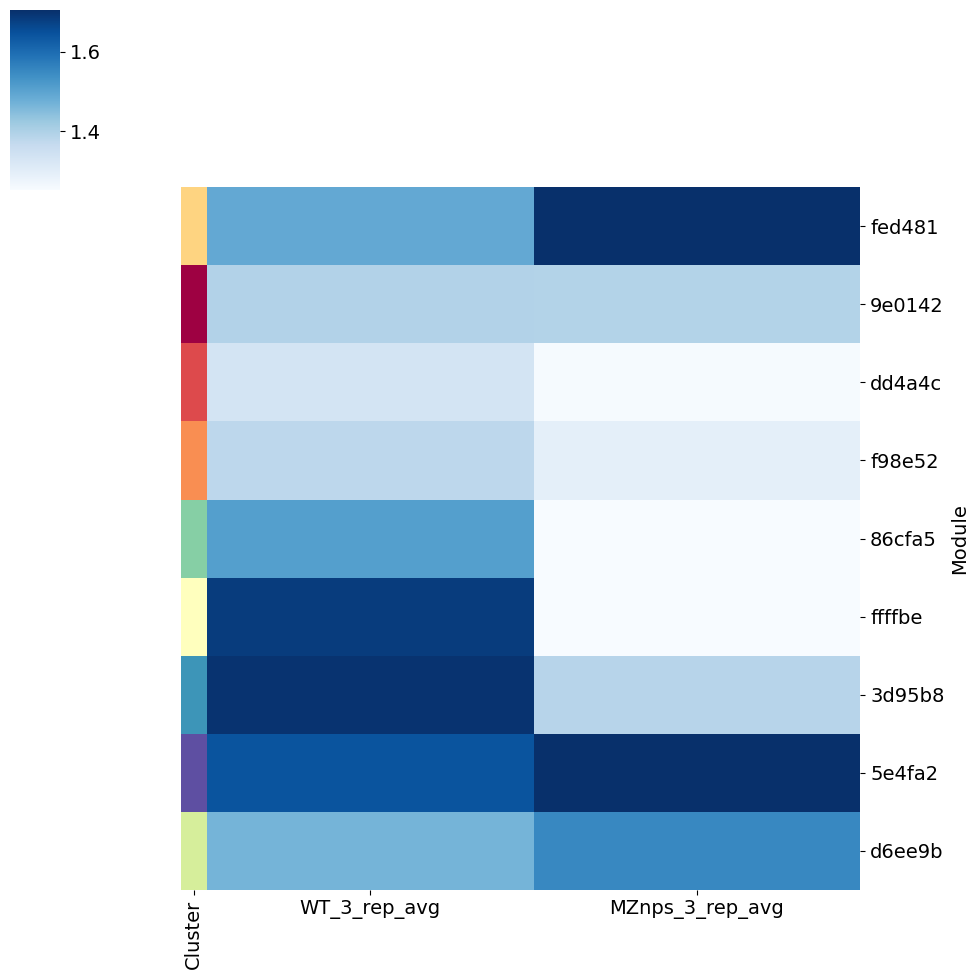

In [30]:
colour_max = data_df.stack().quantile(.9)
colour_min = data_df.stack().quantile(.1)

plt.figure(figsize=(6, 12))
ax = sns.clustermap(data_df, annot=False, cmap='Blues', yticklabels=True, row_cluster=False, col_cluster=False, vmin=colour_min, vmax=colour_max, row_colors=colours)
# ax = sns.clustermap(data_df, annot=False, cmap='Blues', yticklabels=True, standard_scale=0, row_cluster=False, col_cluster=False)
# ax = sns.heatmap(data_df, annot=False, cmap='Blues', yticklabels=True, square=True)
# plt.savefig(f'{syncdir}/scMZnps_HVG_cluster_Active_Enhancer_Accessibility_MZnps_Liyun_data.pdf')
plt.show()
